<a href="https://colab.research.google.com/github/pdrobny/Bitcoin-Trading-Agent/blob/main/yahoo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install gspread google-auth

In [ ]:
#from google.colab import userdata
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import gspread
from google.colab import auth
import google.auth



#import google.generativeai as genai

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# load files from google drive
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the ticker symbol and interval
ticker_symbol = "BTC-USD"  # Example: Bitcoin USD
interval = "1h"

# Get the ticker data
ticker_data = yf.Ticker(ticker_symbol)

# Get historical data for the specified interval
hist_data = ticker_data.history(interval=interval)

# Display the historical data
display(hist_data.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2025-07-22 15:00:00+00:00,119114.070312,119201.562500,118779.609375,118934.039062,0,0.0,0.0
2025-07-22 16:00:00+00:00,118956.328125,119389.148438,118711.718750,118715.750000,0,0.0,0.0
2025-07-22 17:00:00+00:00,118728.062500,119242.125000,118489.351562,119222.640625,758259712,0.0,0.0
2025-07-22 18:00:00+00:00,119237.117188,120200.484375,119155.875000,119942.929688,0,0.0,0.0
2025-07-22 19:00:00+00:00,119809.140625,119866.648438,119224.718750,119278.296875,0,0.0,0.0


In [ ]:
def calculate_rsi(data, window):
    """Calculates the Relative Strength Index (RSI) for a given dataset."""
    delta = data['Close'].diff()
    gain = delta.copy()
    loss = delta.copy()

    gain[gain < 0] = 0
    loss[loss > 0] = 0

    avg_gain = gain.ewm(com=window-1, adjust=False).mean()
    avg_loss = abs(loss.ewm(com=window-1, adjust=False).mean())

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Calculate RSI with a window of 14 (common setting)
hist_data['RSI'] = calculate_rsi(hist_data, 14)

# Display the data with RSI
display(hist_data.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits,RSI
Datetime,,,,,,,,
2025-07-22 15:00:00+00:00,119114.070312,119201.562500,118779.609375,118934.039062,0,0.0,0.0,NaN
2025-07-22 16:00:00+00:00,118956.328125,119389.148438,118711.718750,118715.750000,0,0.0,0.0,0.000000
2025-07-22 17:00:00+00:00,118728.062500,119242.125000,118489.351562,119222.640625,758259712,0.0,0.0,15.155274
2025-07-22 18:00:00+00:00,119237.117188,120200.484375,119155.875000,119942.929688,0,0.0,0.0,31.128140
2025-07-22 19:00:00+00:00,119809.140625,119866.648438,119224.718750,119278.296875,0,0.0,0.0,26.222537


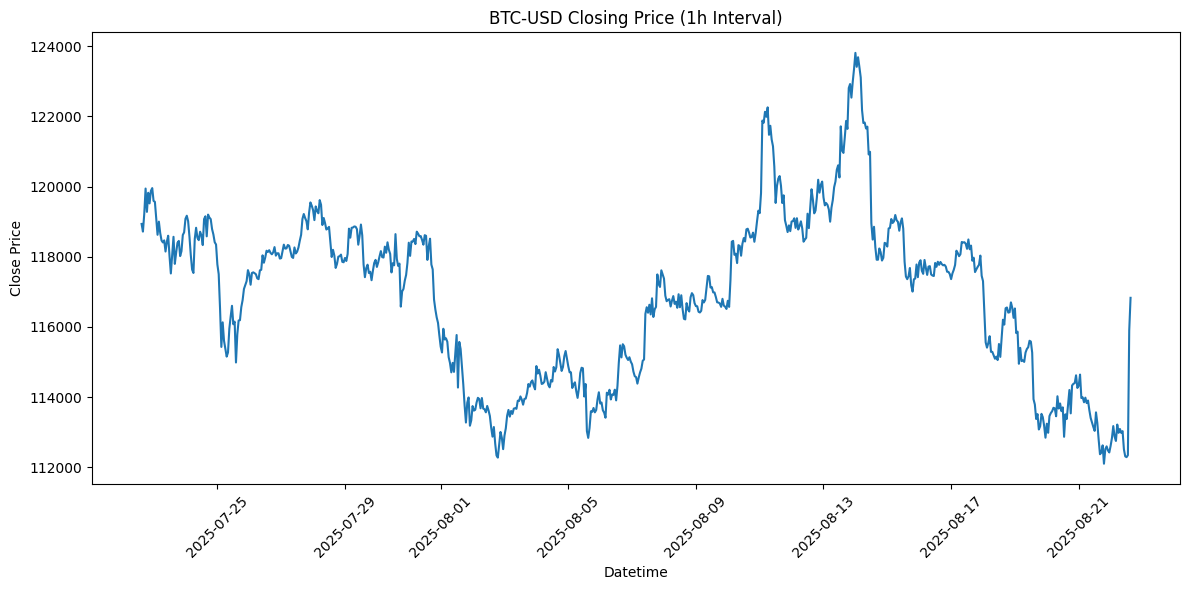

In [ ]:
# Plot the closing price
plt.figure(figsize=(12, 6))
sns.lineplot(data=hist_data, y='Close', x=hist_data.index)
plt.title(f'{ticker_symbol} Closing Price ({interval} Interval)')
plt.xlabel('Datetime')
plt.ylabel('Close Price')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Export the `hist_data` DataFrame to a Google Sheet.

In [ ]:
# autenicate user for access to sheets and drive
auth.authenticate_user()

**Reasoning**:
The previous step authenticated the user, now authorize the Colab environment to access Google Drive and Sheets by setting up the credentials.



In [ ]:

# Get the credentials using google.auth
creds, project = google.auth.default()

# Authorize gspread with the obtained credentials
gc = gspread.authorize(creds)

**Reasoning**:
The error indicates that the Timestamp object in the DataFrame index is not JSON serializable. This happens when trying to convert the DataFrame to a list of lists directly. To fix this, the Timestamp objects need to be converted to strings before updating the Google Sheet.



In [ ]:
sheet_name = "BTC-USD Historical Data"

try:
    # Attempt to open the spreadsheet
    sh = gc.open(sheet_name)
except gspread.SpreadsheetNotFound:
    # If not found, create a new one
    sh = gc.create(sheet_name)
    print(f"Created new spreadsheet: {sheet_name}")

# Get the first worksheet
worksheet = sh.sheet1

# Clear existing data
worksheet.clear()

# Convert DataFrame to list of lists including header, converting Timestamp to string
data_to_export = [hist_data.columns.tolist()] + hist_data.reset_index().astype(str).values.tolist()

# Update the worksheet
worksheet.update(data_to_export)

print(f"Successfully exported data to Google Sheet: {sheet_name}")

Successfully exported data to Google Sheet: BTC-USD Historical Data
